In [129]:
import numpy as np
import pandas as pd
import cv2
import os
import math
import matplotlib.pyplot as plt

from skimage.measure import label, regionprops

In [130]:
## Paths to access Control (c) and PD (pd) segmented images
path = '/Users/HOMEDRIVE/data'
c_path = 'control images'
pd_path = 'pd images'

In [131]:
## Files listed
c_files = os.listdir(os.path.join(path, c_path))
pd_files = os.listdir(os.path.join(path, pd_path))

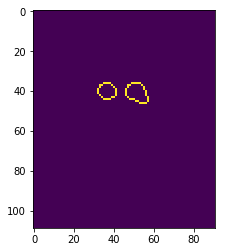

In [217]:
img = cv2.imread(os.path.join(path, pd_path, pd_files[2]), 0)
plt.imshow(img)

In [133]:
## Computes tan inverse between 0 to 2pi
def atan0to2pi (xx, yy):
    z = xx/yy
    if (xx >= 0) and (yy >= 0):
        theta = math.atan(z)
    elif (xx < 0):
        theta = math.atan(z) + math.pi
    elif (xx >= 0) and (yy < 0):
        theta = math.atan(z) + (2 * math.pi)
    return theta

In [195]:
## Computes 8 sampled points such that striatum boundary is divided into 8 segments 
def ComputeSuper8 (boundPel, theta):
    sampled_8pts = np.zeros((8,2))
    angles = [0, 45, 90, 135, 180, 255, 270, 315]
    
    for i in range(len(angles)):
        ## finds the point closest to required angle 
        theta_ang_diff = [th - ((angles[i]*math.pi)/180) for th in theta]
        diff_ang = [abs(e_val) for e_val in theta_ang_diff]
        idx = diff_ang.index(min(diff_ang))
        if (i > 0):
            if (sampled_8pts[i-1].all() == sampled_8pts[i].all()):
                sorted_diffang = sorted(diff_ang)
                idx = diff_ang.index(sorted_diffang[1])  
        sampled_8pts[i][0] = boundPel[idx][0]
        sampled_8pts[i][1] = boundPel[idx][1] 
    
    return sampled_8pts

In [159]:
## Gives 8 sampled points on each left and right striatum
def LR_landmarks (center_L, center_R, boundPel_L, boundPel_R):
    theta_L = []
    for i in range(len(boundPel_L)):
        centroid_x = center_L[0]
        centroid_y = center_L[1]
        borderPel_x = boundPel_L[i][0]
        borderPel_y = boundPel_L[i][1]
        xx = borderPel_x - centroid_x
        yy = borderPel_y - centroid_y
        theta = atan0to2pi(xx, yy)
        theta_L.append(theta)

    
    theta_R = []
    for i in range(len(boundPel_R)):
        centroid_x = center_R[0]
        centroid_y = center_R[1]
        borderPel_x = boundPel_R[i][0]
        borderPel_y = boundPel_R[i][1]
        xx = borderPel_x - centroid_x
        yy = borderPel_y - centroid_y
        theta = atan0to2pi(xx, yy)
        theta_R.append(theta)
    
    sampled_8pts_L = ComputeSuper8(boundPel_L, theta_L)
    sampled_8pts_R = ComputeSuper8(boundPel_R, theta_R)
    
    return sampled_8pts_L, sampled_8pts_R
    

In [160]:
## Computes radial (rad) features
def RadFeat (center, sampled_pts):
    centroid_x = center[0]
    centroid_y = center[1]
    rad_dist = []
    for i in sampled_pts:
        borderPel_x = i[0]
        borderPel_y = i[1]
        dist = math.sqrt(((borderPel_x - centroid_x)**2) + ((borderPel_y - centroid_y)**2))
        rad_dist.append(dist)
    return rad_dist

In [161]:
## Computes gradient (grad) features
def GradFeat (sampled_pts):
    sampled_pts = list(sampled_pts)
    sampled_pts.append(sampled_pts[0])
    grad_val = []
    for i in range(len(sampled_pts)-1):
        borderPel_x1 = sampled_pts[i][0]
        borderPel_y1 = sampled_pts[i][1]
        borderPel_x2 = sampled_pts[i+1][0]
        borderPel_y2 = sampled_pts[i+1][1]
        xx = borderPel_x2 - borderPel_x1
        yy = borderPel_y2 - borderPel_y1
        grad = atan0to2pi (xx, yy)
        grad_val.append(grad)
    return grad_val

# Example to see sampled 8 points

In [214]:
img = cv2.imread(os.path.join(path, pd_path, pd_files[2]), 0)
img = img/255
img1 = label(img) #labels each region in the image 
props = regionprops(img1) #gives region properties for labeled image

center_1 = props[0].centroid
center_2 = props[1].centroid
if (center_1[1] > center_2[1]):
    props_L = props[1]
    props_R = props[0]
else:
    props_L = props[0]
    props_R = props[1]

center_L = props_L.centroid
center_R = props_R.centroid
        
boundPel_L = props_L.coords
boundPel_R = props_R.coords
        
sampled_8pts_L, sampled_8pts_R = LR_landmarks (center_L, center_R, boundPel_L, boundPel_R)

In [220]:
temp = list(boundPel_R)
coor_y = []
coor_x = []
for i in temp:
    coor_x.append(i[0])
    coor_y.append(i[1])
    
temp = list(boundPel_L)
coor_y1 = []
coor_x1 = []
for i in temp:
    coor_x1.append(i[0])
    coor_y1.append(i[1])

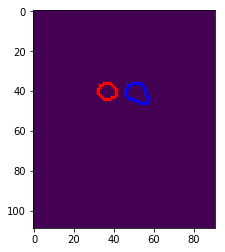

In [221]:
plt.imshow(img)
plt.scatter(x=coor_y, y=coor_x, c='b', s=5)
plt.scatter(x=coor_y1, y=coor_x1, c='r', s=5)

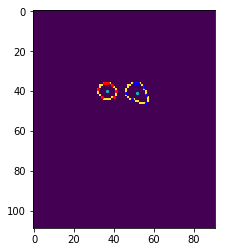

In [222]:
sampled_8pts_L = list(sampled_8pts_L)
#sampled_8pts_L
pts_x = [sampled_8pts_L[0][0], sampled_8pts_L[1][0], sampled_8pts_L[2][0], sampled_8pts_L[3][0], sampled_8pts_L[4][0], sampled_8pts_L[5][0], sampled_8pts_L[6][0], sampled_8pts_L[7][0]]
pts_y = [sampled_8pts_L[0][1], sampled_8pts_L[1][1], sampled_8pts_L[2][1], sampled_8pts_L[3][1], sampled_8pts_L[4][1], sampled_8pts_L[5][1], sampled_8pts_L[6][1], sampled_8pts_L[7][1]]
pts_x1 = [sampled_8pts_R[0][0], sampled_8pts_R[1][0], sampled_8pts_R[2][0], sampled_8pts_R[3][0], sampled_8pts_R[4][0], sampled_8pts_R[5][0], sampled_8pts_R[6][0], sampled_8pts_R[7][0]]
pts_y1 = [sampled_8pts_R[0][1], sampled_8pts_R[1][1], sampled_8pts_R[2][1], sampled_8pts_R[3][1], sampled_8pts_R[4][1], sampled_8pts_R[5][1], sampled_8pts_R[6][1], sampled_8pts_R[7][1]]

pts_xc = center_L[0]
pts_yc = center_L[1]
pts_x1c = center_R[0]
pts_y1c = center_R[1]
i=5
plt.imshow(img)
plt.scatter(x=pts_y, y=pts_x, c='r', s=5)
plt.scatter(x=pts_y1, y=pts_x1, c='b', s=5)
plt.scatter(x=pts_yc, y=pts_xc, c='c', s=5)
plt.scatter(x=pts_y1c, y=pts_x1c, c='c', s=5)

# Feature computation for all subjects

In [211]:

c_imgs = []
c_rad_feat_L = []
c_rad_feat_R = []
c_grad_feat_L = []
c_grad_feat_R = []
for i in c_files:
    if ('.png' in i)==True:
        img = cv2.imread(os.path.join(path, c_path, i), 0)
        img = img/255
        img1 = label(img) #labels each region in the image 
        props = regionprops(img1) #gives region properties for labeled image
        
        # Making sure regions are left and right striata respectively
        center_1 = props[0].centroid
        center_2 = props[1].centroid
        if (center_1[1] > center_2[1]):
            props_L = props[1]
            props_R = props[0]
        else:
            props_L = props[0]
            props_R = props[1]

        center_L = props_L.centroid
        center_R = props_R.centroid
        
        boundPel_L = props_L.coords
        boundPel_R = props_R.coords
        
        sampled_8pts_L, sampled_8pts_R = LR_landmarks (center_L, center_R, boundPel_L, boundPel_R)
        
        rad_feats_L = RadFeat(center_L, sampled_8pts_L)
        rad_feats_R = RadFeat(center_R, sampled_8pts_R)
        
        grad_feats_L = GradFeat(sampled_8pts_L)
        grad_feats_R = GradFeat(sampled_8pts_R)
        
        c_imgs.append(img)
        c_rad_feat_L.append(rad_feats_L)
        c_rad_feat_R.append(rad_feats_R)
        c_grad_feat_L.append(grad_feats_L)
        c_grad_feat_R.append(grad_feats_R)
        
c_imgs = np.array(c_imgs)


pd_imgs = []
pd_rad_feat_L = []
pd_rad_feat_R = []
pd_grad_feat_L = []
pd_grad_feat_R = []
for i in pd_files:
    if ('.png' in i)==True:
        img = cv2.imread(os.path.join(path, pd_path, i), 0)
        img = img/255
        img1 = label(img) #labels each region in the image
        props = regionprops(img1) #gives region properties for labeled image
        
        center_1 = props[0].centroid
        center_2 = props[1].centroid
        if (center_1[1] > center_2[1]):
            props_L = props[1]
            props_R = props[0]
        else:
            props_L = props[0]
            props_R = props[1]

        center_L = props_L.centroid
        center_R = props_R.centroid
        
        boundPel_L = props_L.coords
        boundPel_R = props_R.coords
        
        sampled_8pts_L, sampled_8pts_R = LR_landmarks (center_L, center_R, boundPel_L, boundPel_R)
        
        rad_feats_L = RadFeat(center_L, sampled_8pts_L)
        rad_feats_R = RadFeat(center_R, sampled_8pts_R)
        
        grad_feats_L = GradFeat(sampled_8pts_L)
        grad_feats_R = GradFeat(sampled_8pts_R)
        
        pd_imgs.append(img)
        pd_rad_feat_L.append(rad_feats_L)
        pd_rad_feat_R.append(rad_feats_R)
        pd_grad_feat_L.append(grad_feats_L)
        pd_grad_feat_R.append(grad_feats_R)
        
pd_imgs = np.array(pd_imgs)


/Users/noopurbhalchandra/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in double_scalars
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/noopurbhalchandra/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in double_scalars
  This is separate from the ipykernel package so we can avoid doing imports until


# Boxplots to see feature range for control and PD

{'whiskers': [<matplotlib.lines.Line2D at 0x1c25868be0>,
 'caps': [<matplotlib.lines.Line2D at 0x1c2586f4e0>,
 'boxes': [<matplotlib.lines.Line2D at 0x1c25868a90>,
 'medians': [<matplotlib.lines.Line2D at 0x1c2586fd30>,
 'fliers': [<matplotlib.lines.Line2D at 0x1c25876198>,
 'means': []}

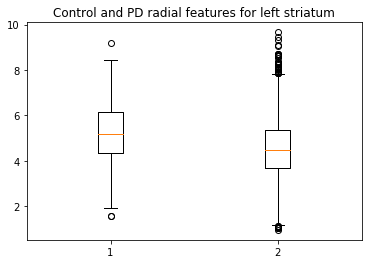

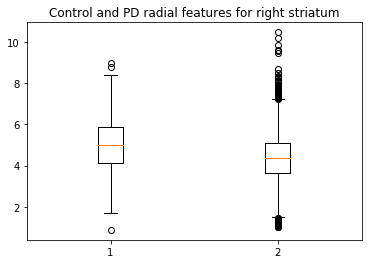

In [212]:
fig1, ax1 = plt.subplots()
rad_L = [c_rad_feat_L[:], pd_rad_feat_L[:]]
ax1.set_title('Control and PD radial features for left striatum')
ax1.boxplot(rad_L)

fig2, ax2 = plt.subplots()
rad_R = [c_rad_feat_R[:], pd_rad_feat_R[:]]
ax2.set_title('Control and PD radial features for right striatum')
ax2.boxplot(rad_R)